<a href="https://colab.research.google.com/github/pahwa1902/Learning/blob/master/VehicleLoanDefault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, ensemble
from sklearn.metrics import accuracy_score, precision_score, classification_report, f1_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import random
from sklearn.feature_extraction import FeatureHasher
import tensorflow as tf
import seaborn as sns
from scipy import stats

In [627]:
train_data = pd.read_csv('/content/drive/My Drive/LoanData/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/LoanData/test_bqCt9Pv.csv')

([<matplotlib.patches.Wedge at 0x7f7321cb8588>,
 [Text(-0.85398028147408, 0.6933380696698049, 'not_default'),
  Text(0.8539802814740799, -0.693338069669805, 'default')])

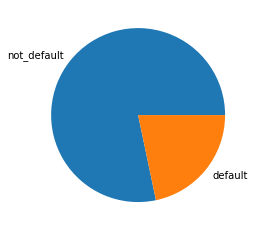

In [110]:
label_dist = train_data.groupby('loan_default').size()
plt.pie(label_dist,labels=['not_default','default'])

In [ ]:
train_data.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [274]:
Bins_Pincode = 20
Length = len(train_data)
divide_flag = True
Scale = 100
Bucket = 5

In [275]:
def generate_features(x,b,column):
  data_value = str(x[b])
  column.append(data_value)

In [276]:
def feature_hashing(data,train,b):
  data_column = []
  data.apply(lambda x:generate_features(x,b,data_column),axis=1)
  if (train):
    h = FeatureHasher(n_features=Bucket,input_type='string')
    hash_values = h.fit_transform(data_column)
    
  else:
    hash_values = h.transform(data_column)
  new_data = pd.concat([data,assign_hash(hash_values)],axis=1)
  return new_data

In [277]:
def assign_hash(hash_values):
  
  hash_dict = {"hashing-"+str(i):hash_values[:,i].toarray().reshape(-1,) for i in range(Bucket)}
  hash_df = pd.DataFrame(hash_dict)
  return hash_df

In [278]:
def replace_pin_data(x,value,data):
  if (x in value):
    data.append(1)
  else:
    data.append(0)

In [279]:
def binpincode(data,column):
  
  pindata,b = pd.cut(data[column],Bins_Pincode,retbins=True)
  bin = pindata.unique()
  for i in range(len(bin)):
    data_column=[]
    data = data.reindex(columns=data.columns.tolist()+["pincode_bin_"+str(i)])
    data[column].apply(lambda x:replace_pin_data(x,bin[i],data_column))
    data["pincode_bin_"+str(i)] = data_column
  return data

([<matplotlib.patches.Wedge at 0x7efd40304ef0>,
 [Text(0.2265383130050059, 1.0764201748113262, 'Salaried'),
  Text(-0.22653831300500626, -1.0764201748113262, 'Self Employed')])

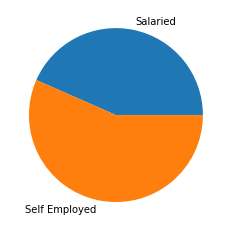

In [192]:
train_data['Employment.Type'].unique()
emp_data=train_data.groupby('Employment.Type').size()
plt.pie(emp_data,labels=['Salaried','Self Employed'])

In [280]:
def date2days(data):
  value = data.split()
  
  year = value[0]
  year_value = int(year[0])
  
  if(len(value)>1):
    month = value[1]
    month_value = int(month[0])
  else:
    month_value = 0
  days = (year_value*365 + (month_value//2)*30 + (month_value-(month_value//2))*31)
  if(days>0):
    return days
  else:
    return 1
  


In [281]:
def transformdate(initial_data,column):
  initial_data[column]=initial_data[column].apply(lambda x:date2days(x))
  return initial_data

In [282]:
def add_column(columns,data):
  data=data.reindex(columns=data.columns.tolist()+columns)
  return data

In [283]:
def replace_cat_data(x,value,data):
  if(x==value):
    data.append(1)
  else:
    data.append(0)

In [284]:
def cat2int(initial_data,columns):
  for j in columns:
    values = initial_data[j].unique().tolist()
    data = add_column(values,initial_data)
    for i in values:
      data_column = []
      data[j].apply(lambda x:replace_cat_data(x,i,data_column))
      data[i] = data_column
  return data

In [285]:
def div(x,column,a,b):
  if(x[a]!=0 and x[b]!=0):
    column.append(x[a]/x[b])
  else:
    column.append(1/Length)

In [286]:
def divide_columns(a,b,result,initial_data):
  if(divide_flag):
    data = add_column([result],initial_data)
    data[result] = (data[a]+1)/(data[b]+Length)
  else:
    data_column=[]
    data.apply(div(data_column,a,b),axis=1)
    data[result] = data_column
  return data

In [287]:
def total_columns(a,b,result,initial_data):
  data = add_column([result],initial_data)
  data[result] = data[a]+data[b]
  return data

In [288]:
def difference_columns(a,b,result,initial_data):
  data = add_column([result],initial_data)
  data[result] = data[a]-data[b]
  return data

In [553]:
def sqrttransform(columns,data):
  for i in columns:
    data[i] = np.sqrt(data[i])
  return data

In [628]:
remove_columns = ['UniqueID','branch_id','supplier_id','manufacturer_id','Employee_code_ID','DisbursalDate','Date.of.Birth','DisbursalDate','State_ID','Current_pincode_ID','Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION']
categorical_columns = ['Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','State_ID']
sqrt_columns = ['ltv','Age in days','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NEW.ACCTS.IN.LAST.SIX.MONTHS','PERFORM_CNS.SCORE','PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','Proportion of active accounts',
                'Proportion of inquries in credit history','Proportion of overdue accounts','total_active_accounts','total_overdue_accounts']


In [629]:
final_train_label = train_data.pop('loan_default')

In [630]:
def transform_data(initial_data,train):
  
  data = cat2int(initial_data,categorical_columns)
  
  data = divide_columns('PRI.ACTIVE.ACCTS','PRI.NO.OF.ACCTS','Proportion of active accounts',data)
  data = divide_columns('PRI.OVERDUE.ACCTS', 'PRI.ACTIVE.ACCTS','Proportion of overdue accounts',data)
  
  data = divide_columns('PRI.CURRENT.BALANCE','PRI.ACTIVE.ACCTS','Balance per account',data)
 
  data = divide_columns('PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT','Proportion of sanction amount disbursed',data)

  data = total_columns('SEC.ACTIVE.ACCTS','PRI.ACTIVE.ACCTS','total_active_accounts',data)
  data = total_columns('SEC.OVERDUE.ACCTS','PRI.OVERDUE.ACCTS','total_overdue_accounts',data)
  data = total_columns('SEC.CURRENT.BALANCE','PRI.CURRENT.BALANCE','total_current_balance',data)
  data = total_columns('SEC.DISBURSED.AMOUNT','PRI.DISBURSED.AMOUNT','total_disbursed_amount',data)
  
  data = difference_columns('DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NEW.ACCTS.IN.LAST.SIX.MONTHS','Proportion of deliquent account',data)
  
  data = transformdate(data,'CREDIT.HISTORY.LENGTH')
  data = divide_columns('NO.OF_INQUIRIES','CREDIT.HISTORY.LENGTH','Proportion of inquries in credit history',data)
  
  data = transformdate(data,'AVERAGE.ACCT.AGE')
  data = difference_columns('CREDIT.HISTORY.LENGTH','AVERAGE.ACCT.AGE','difference in average account age and credit history',data)
  
  data['DisbursalDate'] = pd.to_datetime(data['DisbursalDate'])
  data['Date.of.Birth'] = pd.to_datetime(data['Date.of.Birth'])
  
  data = difference_columns('DisbursalDate','Date.of.Birth','Age in days',data)
  data['Age in days'] = data['Age in days'].dt.days
  #data = feature_hashing(data,train,'Current_pincode_ID')
  if(train):
    negative_age = data[data['Age in days']<=0].index
    data.drop(negative_age,axis=0,inplace=True)
  else:
    negative_age=[]
  data = sqrttransform(sqrt_columns,data)
  data = binpincode(data,'Current_pincode_ID')
  data = data.drop(remove_columns,axis=1)
  
  return data, negative_age

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [584]:
def normalize(data,columns):
  for i in columns:
    data[i] = ((data[i]-min(data[i]))/(max(data[i])-min(data[i])))*Scale
  return data

In [585]:
normalize_columns = ['disbursed_amount', 'asset_cost', 'ltv','PERFORM_CNS.SCORE','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS','SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','total_active_accounts','total_overdue_accounts','total_current_balance','total_disbursed_amount','total_disbursed_amount','Proportion of inquries in credit history','difference in average account age and credit history','Age in days','Proportion of active accounts','Proportion of overdue accounts','Balance per account','Proportion of sanction amount disbursed']

In [631]:
final_train_data, negative_agedays = transform_data(train_data,True)


In [632]:
final_train_label.drop(negative_agedays,axis=0,inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


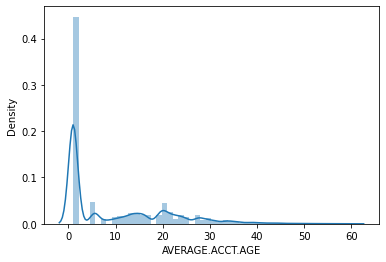

In [571]:
sns.distplot(final_train_data['AVERAGE.ACCT.AGE'],label='account age')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


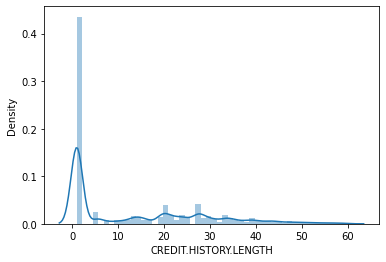

In [565]:
sns.distplot(final_train_data['CREDIT.HISTORY.LENGTH'],label='credit_history_length')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


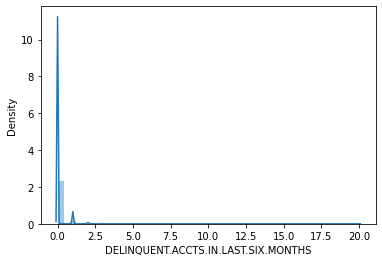

In [221]:
sns.distplot(final_train_data['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'],label='Deliquenet accounts')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


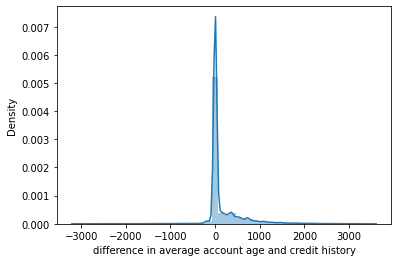

In [222]:
sns.distplot(final_train_data['difference in average account age and credit history'],label='difference in account age and credit history')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


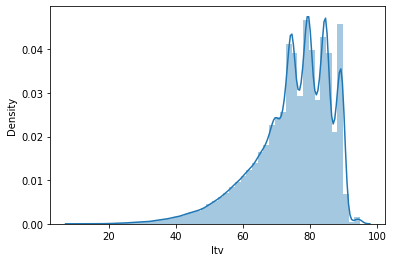

In [223]:
sns.distplot(final_train_data['ltv'],label='ltv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


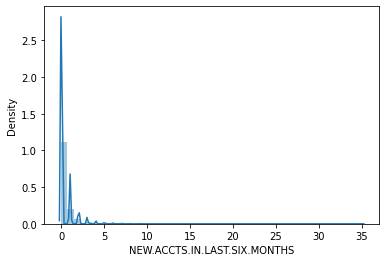

In [226]:
sns.distplot(final_train_data['NEW.ACCTS.IN.LAST.SIX.MONTHS'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


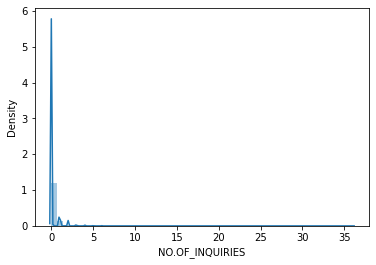

In [227]:
sns.distplot(final_train_data['NO.OF_INQUIRIES'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


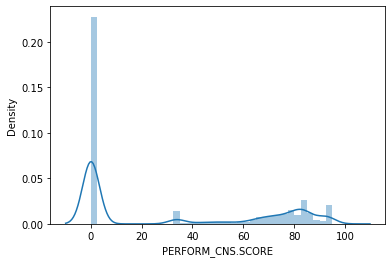

In [478]:
sns.distplot(final_train_data['PERFORM_CNS.SCORE'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


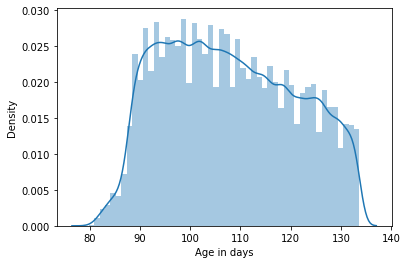

In [575]:
sns.distplot(final_train_data['Age in days'])

In [633]:
normalized_data = normalize(final_train_data,normalize_columns)

In [634]:
data_length = int(0.95*len(normalized_data))
train_normalize_data = normalized_data[:data_length]
train_label = final_train_label[:data_length]

validate_normalize_data = normalized_data[data_length:]
valid_label = final_train_label[data_length:]

In [635]:
logistic = linear_model.LogisticRegression(class_weight={1:4,0:1})


In [ ]:
logistic.fit(train_normalize_data,train_label)

In [637]:
predict = logistic.predict(validate_normalize_data)

In [638]:
f1_score(predict,valid_label)

0.41381700554528655

In [655]:
print(classification_report(predict,valid_label))

              precision    recall  f1-score   support

           0       0.46      0.84      0.59      4360
           1       0.71      0.29      0.41      6148

    accuracy                           0.52     10508
   macro avg       0.58      0.56      0.50     10508
weighted avg       0.61      0.52      0.49     10508



In [640]:
final_test_data = transform_data(test_data,False)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
final_test_data

In [ ]:
predict_test = logistic.predict(final_test_data)

In [457]:
test_data = test_data.reindex(columns=final_test_data.columns.tolist()+['loan_default'])

In [ ]:
test_data['loan_default'] = predict_test

In [452]:
final_test_data.to_csv('test_data.csv')

In [453]:
from google.colab import files
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>